In [292]:
import numpy as np
import pandas as pd
from keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [293]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [294]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [295]:
tf.test.is_gpu_available()

2021-12-12 10:49:49.790416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 21733 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:5e:00.0, compute capability: 8.6


True

In [296]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12278908105974017901
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22789292032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5560046342139364211
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:5e:00.0, compute capability: 8.6"
]


2021-12-12 10:49:49.834879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 21733 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:5e:00.0, compute capability: 8.6


In [297]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [298]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [299]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [300]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [301]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [302]:
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_val -= x_train_mean
x_test -= x_train_mean

In [303]:
batch_size= 50
epochs=100

In [304]:
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [305]:
#Fit the augmentation method to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [306]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(
                       monitor='val_loss', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [307]:
#pretrained model : imagenet
vgg_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [308]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [309]:
# mymodel=Sequential()
# #Add the Dense layers along with activation and batch normalization
# mymodel.add(resnet_model)
# mymodel.add(Flatten())


# #Add the Dense layers along with activation and batch normalization
# mymodel.add(Dense(4000,activation=('relu'),input_dim=512))
# mymodel.add(Dense(2000,activation=('relu'))) 
# mymodel.add(Dropout(.4))
# mymodel.add(Dense(1000,activation=('relu'))) 
# mymodel.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
# mymodel.add(Dense(500,activation=('relu')))
# mymodel.add(Dropout(.2))
# mymodel.add(Dense(10,activation=('softmax'))) #This is the classification layer
#Add the Dense layers along with activation and batch normalization
#Lets add the final layers to these base models where the actual classification is done in the dense layers

mymodel= Sequential()
mymodel.add(vgg_model) #Adds the base model (in this case vgg19 to model_1)
mymodel.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

mymodel.add(Dense(1024,activation=('relu'),input_dim=512))
mymodel.add(Dense(512,activation=('relu'))) 
mymodel.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
mymodel.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
mymodel.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [310]:
mymodel.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_56 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_58 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_59 (Dense)             (None, 10)              

In [311]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [312]:
mymodel.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [313]:
x_train.shape[0]//batch_size


70

In [314]:
with tf.device('/gpu:0'):
    mymodel.fit(
        train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/50
70/70 [==============================] - 18s 237ms/step - loss: 1.9429 - accuracy: 0.3130 - val_loss: 1.3930 - val_accuracy: 0.5095
Epoch 2/50
70/70 [==============================] - 11s 161ms/step - loss: 1.1331 - accuracy: 0.6020
Epoch 3/50
70/70 [==============================] - 11s 161ms/step - loss: 0.9181 - accuracy: 0.6795
Epoch 4/50
70/70 [==============================] - 11s 161ms/step - loss: 0.8260 - accuracy: 0.7119
Epoch 5/50
70/70 [==============================] - 11s 160ms/step - loss: 0.7817 - accuracy: 0.7283
Epoch 6/50
20/70 [=======>......................] - ETA: 8s - loss: 0.7259 - accuracy: 0.7454

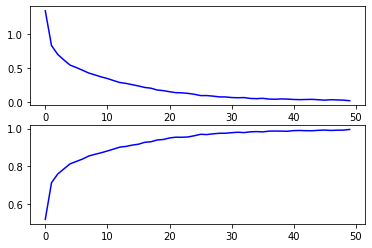

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(mymodel.history.history['loss'],color='b',label='Training Loss') 
ax[0].plot(mymodel.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(mymodel.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(mymodel.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
y_pred=mymodel.predict(x_test).argmax(axis=1)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)


Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

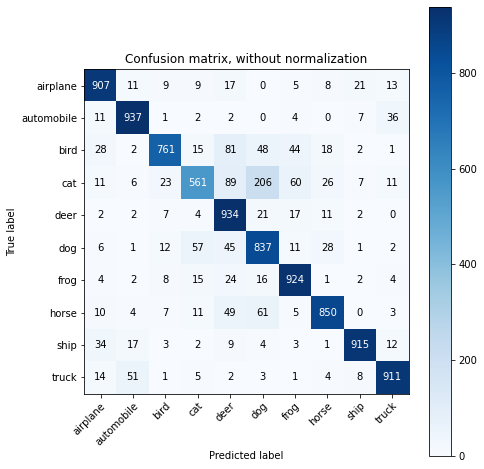

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

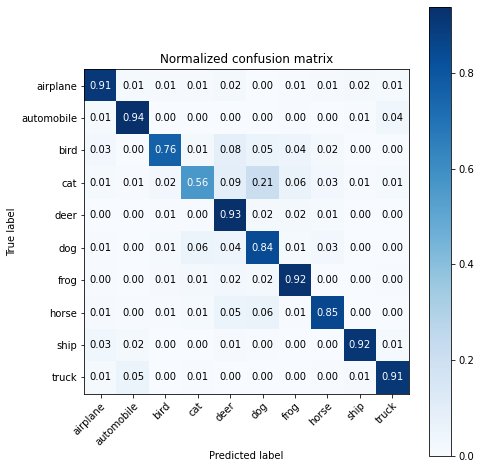

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
scores = mymodel.evaluate(x_test,y_test,verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.8726 - accuracy: 0.8537
Test loss: 0.8726442456245422
Test accuracy: 0.8536999821662903
